In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Subset
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

In [2]:
from data import MIDIDataset, graph_from_tensor
from model import VAE
from utils import plot_struct, dense_from_sparse, muspy_from_dense
from train import VAETrainer

Load trained model:

In [3]:
model = 'models/16barsGNNDEF/'
gpu = True
device_idx = 3

checkpoint = torch.load(os.path.join(model, 'checkpoint'), map_location='cpu')
state_dict = checkpoint['model_state_dict']
params = torch.load(os.path.join(model, 'params'), map_location='cpu')

In [4]:
torch.cuda.set_device(device_idx)

device = torch.device("cuda") if gpu else torch.device("cpu")
print("Device:", device)
print("Device idx:", torch.cuda.current_device())

Device: cuda
Device idx: 3


In [5]:
params

{'training': {'batch_size': 32,
  'num_workers': 4,
  'ds_len': 2842739,
  'tr_len': 1989917,
  'vl_len': 284273,
  'ts_len': 568549},
 'model': {'dropout': 0,
  'batch_norm': True,
  'gnn_n_layers': 8,
  'actsnn_n_layers': 2,
  'd': 512,
  'rnn_n_layers': 1,
  'k_isgn': 3,
  'd_token': 230,
  'd_token_pitches': 131,
  'd_token_dur': 99,
  'n_bars': 16,
  'n_relations': 6,
  'n_tracks': 4,
  'resolution': 8,
  'max_simu_notes': 16},
 'scheduler': {'peak_lr': 5e-05,
  'final_lr_scale': 0.01,
  'warmup_steps': 8000,
  'decay_steps': 800000},
 'optimizer': {'betas': (0.9, 0.98), 'eps': 1e-09, 'lr': 5e-06},
 'beta_annealing': {'beta_update': True,
  'anneal_start': 40000,
  'beta_max': 0.01,
  'step_size': 0.001,
  'anneal_end': 500000}}

In [6]:
vae = VAE(**params['model'], device=device).to(device)
vae.load_state_dict(state_dict)
vae.eval()

VAE(
  (encoder): Encoder(
    (dropout_layer): Dropout(p=0, inplace=False)
    (notes_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (bn_npe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drums_pitch_emb): Linear(in_features=131, out_features=256, bias=True)
    (bn_dpe): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dur_emb): Linear(in_features=99, out_features=256, bias=True)
    (bn_de): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (chord_encoder): Linear(in_features=7680, out_features=512, bias=True)
    (graph_encoder): GraphEncoder(
      (layers): ModuleList(
        (0): RGCNConv(512, 512, num_relations=6)
        (1): RGCNConv(512, 512, num_relations=6)
        (2): RGCNConv(512, 512, num_relations=6)
        (3): RGCNConv(512, 512, num_relations=6)
        (4): RGCNConv(512, 512, num_relations=6)
        (5): RGCNConv(512, 512, num_re

## Reconstruction

Load dataset:

In [ ]:
n_bars = params['model']['n_bars']
bs = params['training']['batch_size']
nw = 4
tr_split = 0.7
val_split = 0.1

ds_dir = "/data/cosenza/datasets/preprocessed_" + str(n_bars) + "bars/"
dataset = MIDIDataset(ds_dir, n_bars=n_bars)
print('Dataset len:', len(dataset))

loader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=nw)

train_len = int(tr_split * len(dataset))
valid_len = int(val_split * len(dataset))
test_len = len(dataset) - train_len - valid_len
tr_set, vl_set, ts_set = random_split(dataset, (train_len, valid_len, test_len))

trainloader = DataLoader(tr_set, batch_size=bs, shuffle=True, num_workers=nw)
validloader = DataLoader(vl_set, batch_size=bs, shuffle=False, num_workers=nw)
testloader = DataLoader(ts_set, batch_size=bs, shuffle=False, num_workers=nw)

tr_len = len(tr_set)
vl_len = len(vl_set)
ts_len = len(ts_set)

print('TR set len:', len(tr_set))
print('VL set len:', len(vl_set))
print('TS set len:', len(ts_set))

#### Reconstruction accuracy (TS)

In [ ]:
models_dir = 'models/test'
trainer = VAETrainer(models_dir, model=vae)

Compute TS losses and accuracies:

In [ ]:
losses, accuracies = trainer.evaluate(testloader)

### Reconstruction

In [ ]:
x_graph = trainloader[0]
x_graph = x_graph.to(device)
x_seq, x_acts, src_mask = x_graph.x_seq, x_graph.x_acts, x_graph.src_mask
tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(device)

# Forward pass, get the reconstructions
with torch.cuda.amp.autocast():
    outputs, mu, log_var = vae(x_seq, x_acts, x_graph, src_mask, tgt_mask)

structure, content = outputs

### Generation
1. sample z from normal (in batch)
2. create dense structure
3. sample structure
4. create graph
5. generate content
6. put structure and content together and create muspy music

In [12]:
from torch_geometric.data import Batch
from utils import midi_from_muspy

def generate_music(vae, z):
    
    # Get structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s > 0.5] = 1
    s[s <= 0.5] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense

In [8]:
z = torch.normal(torch.zeros((params['training']['batch_size'], params['model']['d']),
                             device=device),
                 torch.ones((params['training']['batch_size'], params['model']['d']),
                            device=device))

Compute structure:

In [ ]:
# Get structure and sample
s = vae.decoder.forward_struct(z)
s = torch.sigmoid(s)
#s[s > 0.5] = 1
#s[s <= 0.5] = 0
s = torch.bernoulli(s)
# [bs x bars x tracks x ts]

s = s.detach().cpu().numpy()

Plot a bar:

In [ ]:
plot_struct(s[1][0])

Check for empty bars:

In [ ]:
for i in range(s.shape[0]):
    for j in range(s.shape[1]):
        if not np.any(s[i][j]):
            print("Empty")

From tensor to graph:

In [ ]:
from torch_geometric.data import Batch

graphs = [0 for i in range(params['training']['batch_size'])]

# Create graph structures for each input in the batch
for i in range(s.shape[0]):
    graphs[i] = graph_from_tensor(s[i])

# Create batch from graphs
graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
graphs = graphs.to(device)

Get content:

In [ ]:
# Get content from z and structure
with torch.cuda.amp.autocast():
    c = vae.decoder.forward_content(z, graphs)
    
c = c.detach().cpu().numpy()

In [ ]:
dense = dense_from_sparse(c, s)

In [ ]:
# Collapse bars dimension
dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

size = (
    dense.shape[0],
    dense.shape[1],
    -1,
    dense.shape[4],
    dense.shape[5]
)

dense = dense.reshape(size)

In [ ]:
dense.shape

In [ ]:
track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

# 2
# 22
music = muspy_from_dense(dense[22], track_data, params['model']['resolution'])

In [ ]:
from utils import plot_pianoroll
plot_pianoroll(music)

In [ ]:
from utils import midi_from_muspy

save_dir = "data/music/"
midi_from_muspy(music, save_dir, name='music')

In [41]:
from matplotlib import pyplot as plt
import muspy
def plot_pianoroll(music, save_dir=None, name=None):

    fig, axs_ = plt.subplots(4, sharex=True, figsize=(20,10))
    fig.subplots_adjust(hspace=0)
    axs = axs_.tolist()
    muspy.show_pianoroll(music=music, yticklabel='off', grid_axis='off', axs=axs)
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, name+".png"), dpi=200)

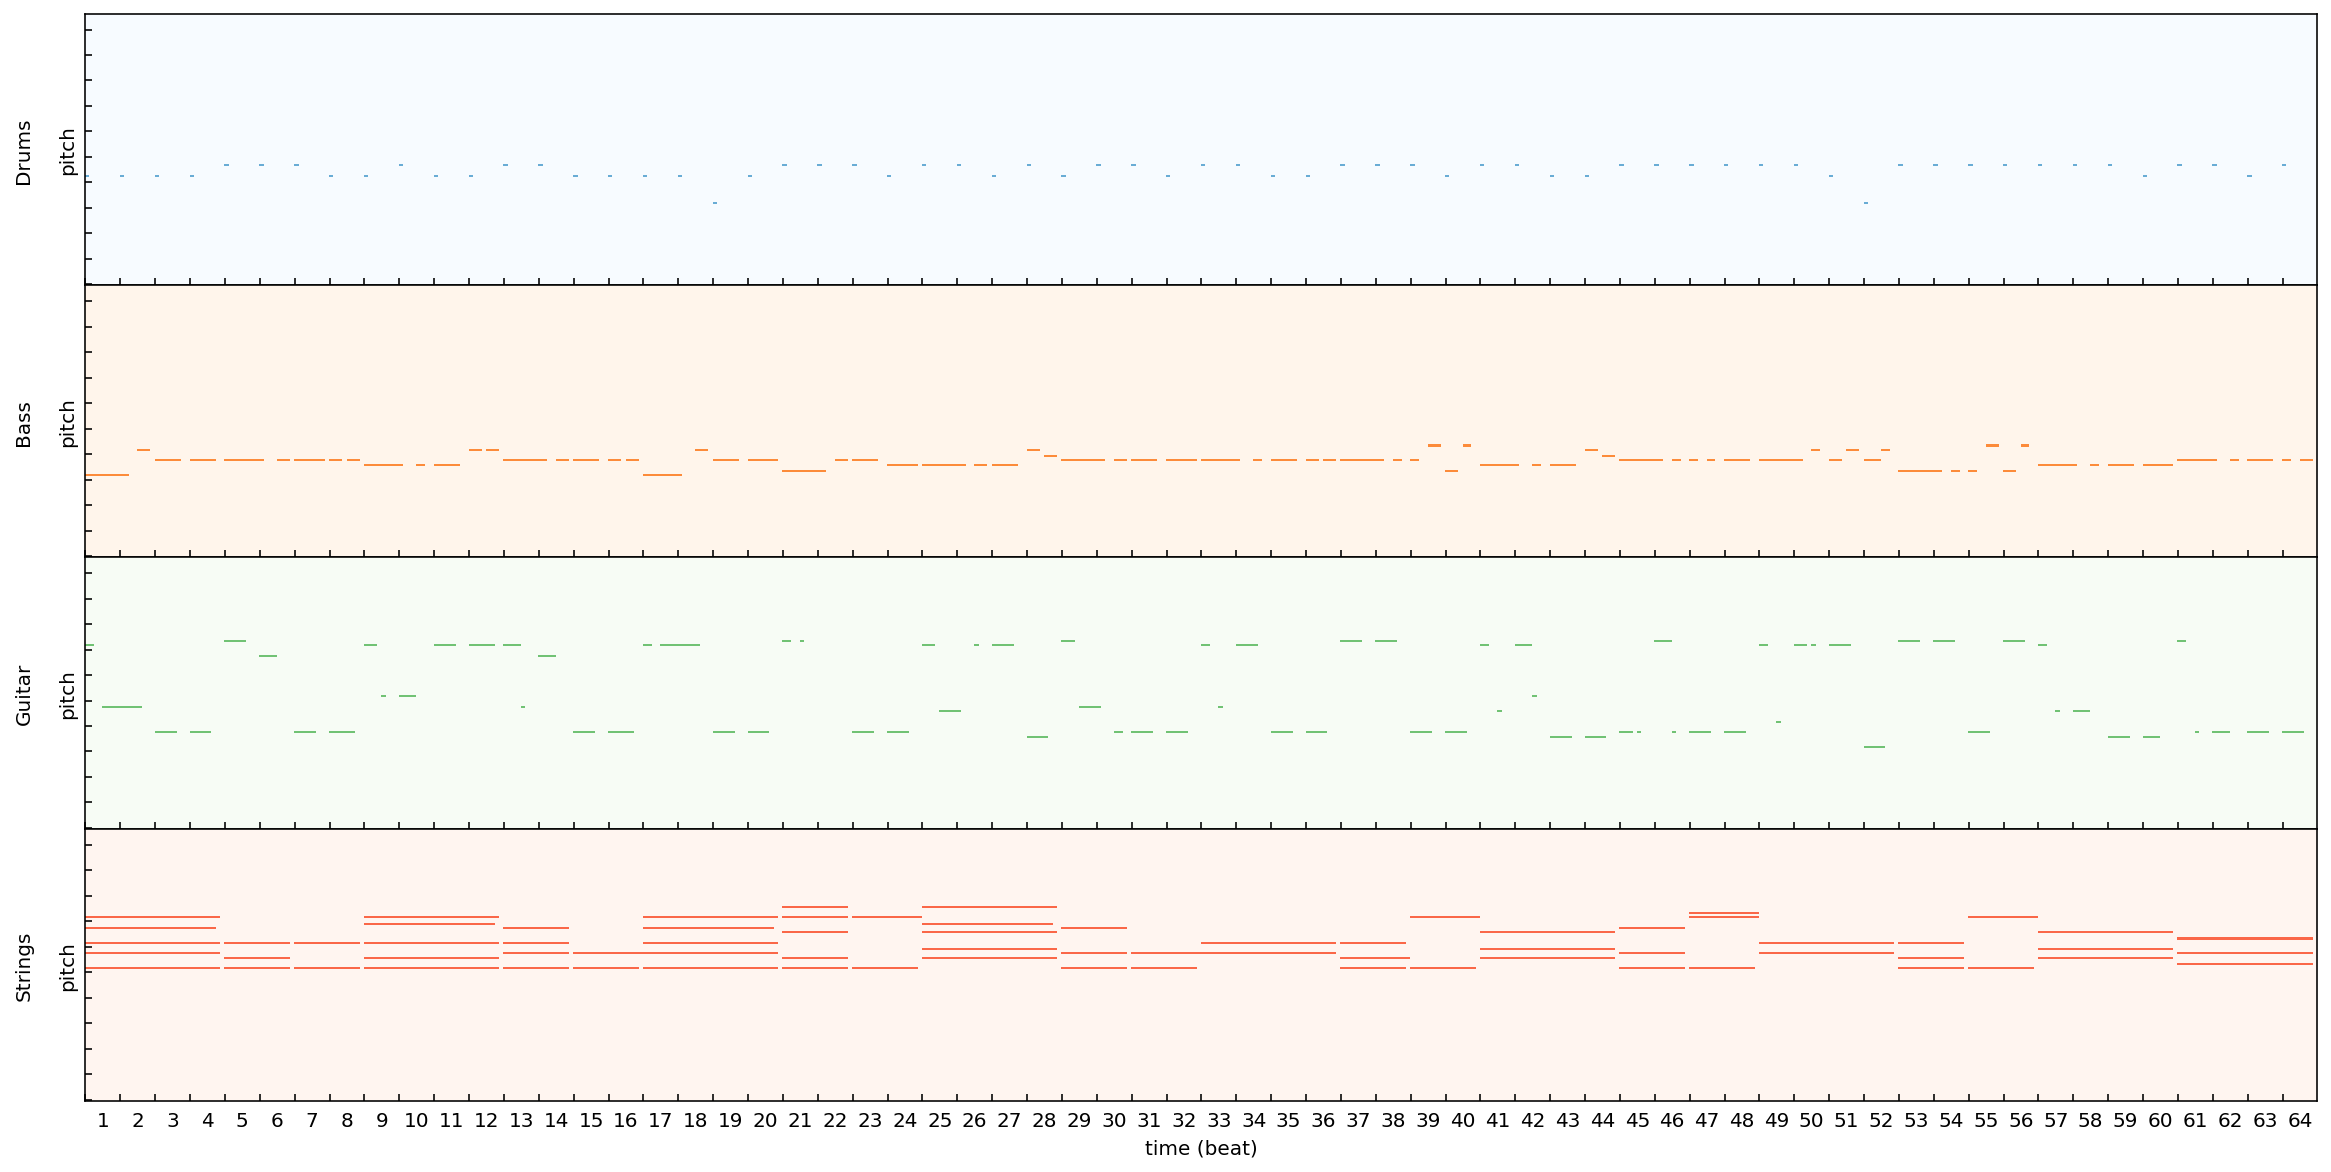

In [42]:
#from utils import plot_pianoroll

z_gen = z[31].repeat(params['training']['batch_size'], 1)

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]
save_dir = "data/music/"

music = generate_music(vae, z_gen)
music = muspy_from_dense(music[0], track_data, params['model']['resolution'])
plot_pianoroll(music, save_dir, name='music')
midi_from_muspy(music, save_dir, name='music')

## Interpolation

In [ ]:
def generate_music(vae, z):
    
    # Get structure and sample
    s = vae.decoder.forward_struct(z)
    s = torch.sigmoid(s)
    s[s > 0.5] = 1
    s[s <= 0.5] = 0
    #s = torch.bernoulli(s)

    s = s.detach().cpu().numpy()
    
    graphs = [0 for i in range(params['training']['batch_size'])]

    # Create graph structures for each input in the batch
    for i in range(s.shape[0]):
        graphs[i] = graph_from_tensor(s[i])

    # Create batch from graphs
    graphs = Batch.from_data_list(graphs, exclude_keys=['batch'])
    graphs = graphs.to(device)
    
    # Get content from z and structure
    with torch.cuda.amp.autocast():
        c = vae.decoder.forward_content(z, graphs)

    c = c.detach().cpu().numpy()
    
    # Compute dense representation (pianoroll with silences)
    dense = dense_from_sparse(c, s)
    
    # Collapse bars dimension
    dense = np.transpose(dense, (0, 2, 1, 3, 4, 5))

    size = (
        dense.shape[0],
        dense.shape[1],
        -1,
        dense.shape[4],
        dense.shape[5]
    )

    dense = dense.reshape(size)
    
    return dense

In [ ]:
z_start = z[2].repeat(params['training']['batch_size'], 1)
z_end = z[30].repeat(params['training']['batch_size'], 1)
# Encode 1 in z1
# Encode 2 in z2

# Linear interpolation between z1 z2
# For each point, produce decoding

In [ ]:
n_interp = 8

track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]
save_dir = "data/music/interpolations"

for i, a in enumerate(np.linspace(0.0 , 1.0, n_interp, endpoint=True)):
    
    print("Generating piece " + str(i) + " out of " + str(n_interp) + "...")
    
    z_curr = z_start + a*(z_end - z_start)
    
    music = generate_music(vae, z_curr)
    music = muspy_from_dense(music[0], track_data, params['model']['resolution'])
    midi_from_muspy(music, save_dir, name='z'+str(i))

print("Finished.")

In [ ]:
music = muspy_from_dense(music[0], track_data, params['model']['resolution'])

save_dir = "data/music/interpolations"
midi_from_muspy(music, save_dir, name='z1')